In [1]:
pip install --force-reinstall agent_system/dist/mesa_restaurant_agents-0.0.1-py3-none-any.whl

In [2]:
import mesa
from mesa_restaurant_agents.model.restaurant_model import RestaurantModel
import pandas as pd

params = {"n_waiters":10, "grid_width":20, "grid_height": 20}

results = mesa.batch_run(
    RestaurantModel,
    parameters=params,
    iterations=1,
    max_steps=500,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

# Handle data conversion with explicit types
df = pd.DataFrame(results)
numeric_cols = ['Step', 'Customer_Count', 'Average_Wait_Time', 'Average_Customer_Satisfaction', 'Profit']
df[numeric_cols] = df[numeric_cols].fillna(0).astype(float)
 
# Get only columns with data
non_empty_cols = [col for col in df.columns if df[col].notna().any()]
df[non_empty_cols].head()

  0%|          | 0/1 [00:00<?, ?it/s]

Step 660, Profit: 0
Active customers: 0
DEBUG: Day 1, minute 665: Active customers: 0, waiters: 10
DEBUG: Kitchen processing - requested orders: 0, prepared orders: 0
DEBUG: Day 1, minute 670: Active customers: 0, waiters: 10
DEBUG: Kitchen processing - requested orders: 0, prepared orders: 0
DEBUG: Day 1, minute 675: Active customers: 0, waiters: 10
DEBUG: Kitchen processing - requested orders: 0, prepared orders: 0
{(7, 17), (3, 7), (5, 1), (17, 3), (5, 13), (3, 13), (19, 9), (11, 5), (5, 19), (9, 17), (19, 15), (1, 9), (11, 11), (13, 11), (15, 5), (7, 1), (1, 15), (13, 17), (7, 19), (3, 9), (5, 3), (17, 5), (9, 1), (3, 15), (19, 11), (11, 7), (9, 19), (13, 1), (19, 17), (1, 11), (11, 13), (15, 7), (7, 3), (1, 17), (13, 19), (3, 11), (5, 5), (17, 7), (9, 3), (3, 17), (19, 1), (17, 13), (11, 9), (13, 3), (19, 19), (1, 13), (11, 15), (15, 9), (7, 5), (1, 19), (15, 15), (3, 1), (5, 7), (17, 9), (9, 5), (3, 19), (19, 3), (17, 15), (9, 11), (1, 3), (13, 5), (11, 17), (15, 11), (7, 7), (15

AttributeError: 'RestaurantModel' object has no attribute 'multi_day_mode'

In [3]:
from mesa_restaurant_agents.model.restaurant_model import RestaurantModel

model = RestaurantModel(n_waiters=10, grid_width=23, grid_height=23)
for i in range(2):
    model.step()

Step 660, Profit: 0
Active customers: 0
DEBUG: Day 1, minute 665: Active customers: 0, waiters: 10
DEBUG: Kitchen processing - requested orders: 0, prepared orders: 0
DEBUG: Day 1, minute 670: Active customers: 0, waiters: 10
DEBUG: Kitchen processing - requested orders: 0, prepared orders: 0


In [4]:
print(results[0])

{'RunId': 0, 'iteration': 0, 'Step': 0, 'n_waiters': 10, 'grid_width': 20, 'grid_height': 20, 'Customer_Count': 0, 'Average_Wait_Time': 0.0, 'Average_Customer_Satisfaction': 100.0, 'Profit': 0, 'Customer_Info': [], 'Daily_Stats': {'day': 1, 'food_revenue': 0, 'tips': 0, 'total_revenue': 0, 'customers_paid': 0, 'customers_left': 0, 'served_customers': 0}, 'Waiter_Info': [{'waiter_nr': 1, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 2, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 3, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 4, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 5, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 6, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 7, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 8, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 9, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'wait

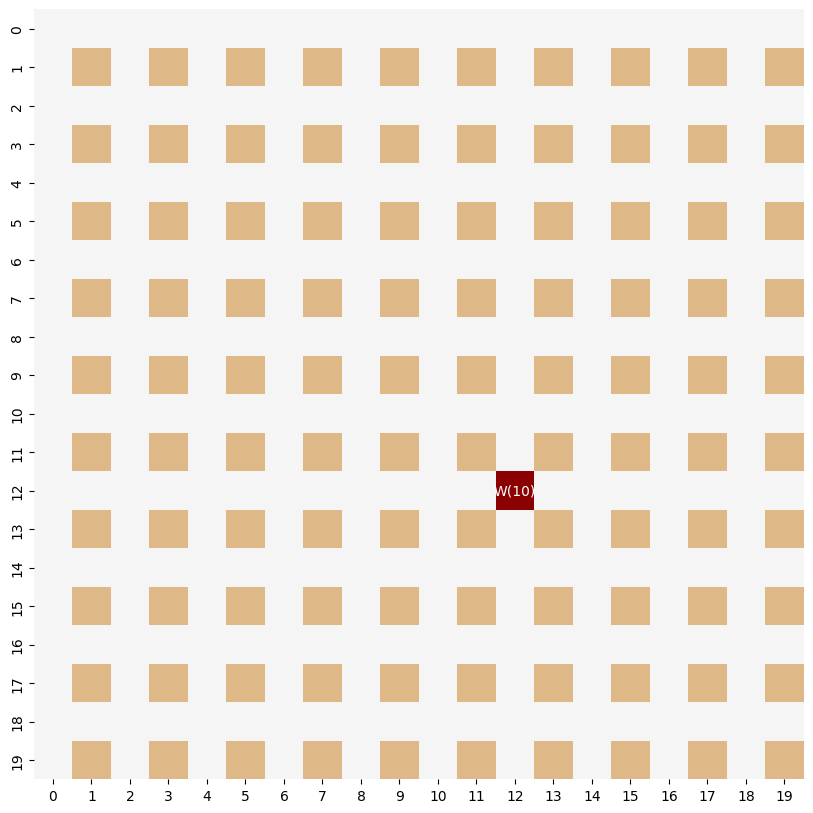

In [5]:
from mesa_restaurant_agents.visualization import *
from mesa_restaurant_agents.visualization import GridAnimator

# Create an instance of GridAnimator
animator = GridAnimator(results)

ani = animator.animate_first_run()
ani.save('animated_heatmap.gif', writer='pillow', fps=2, dpi=80)

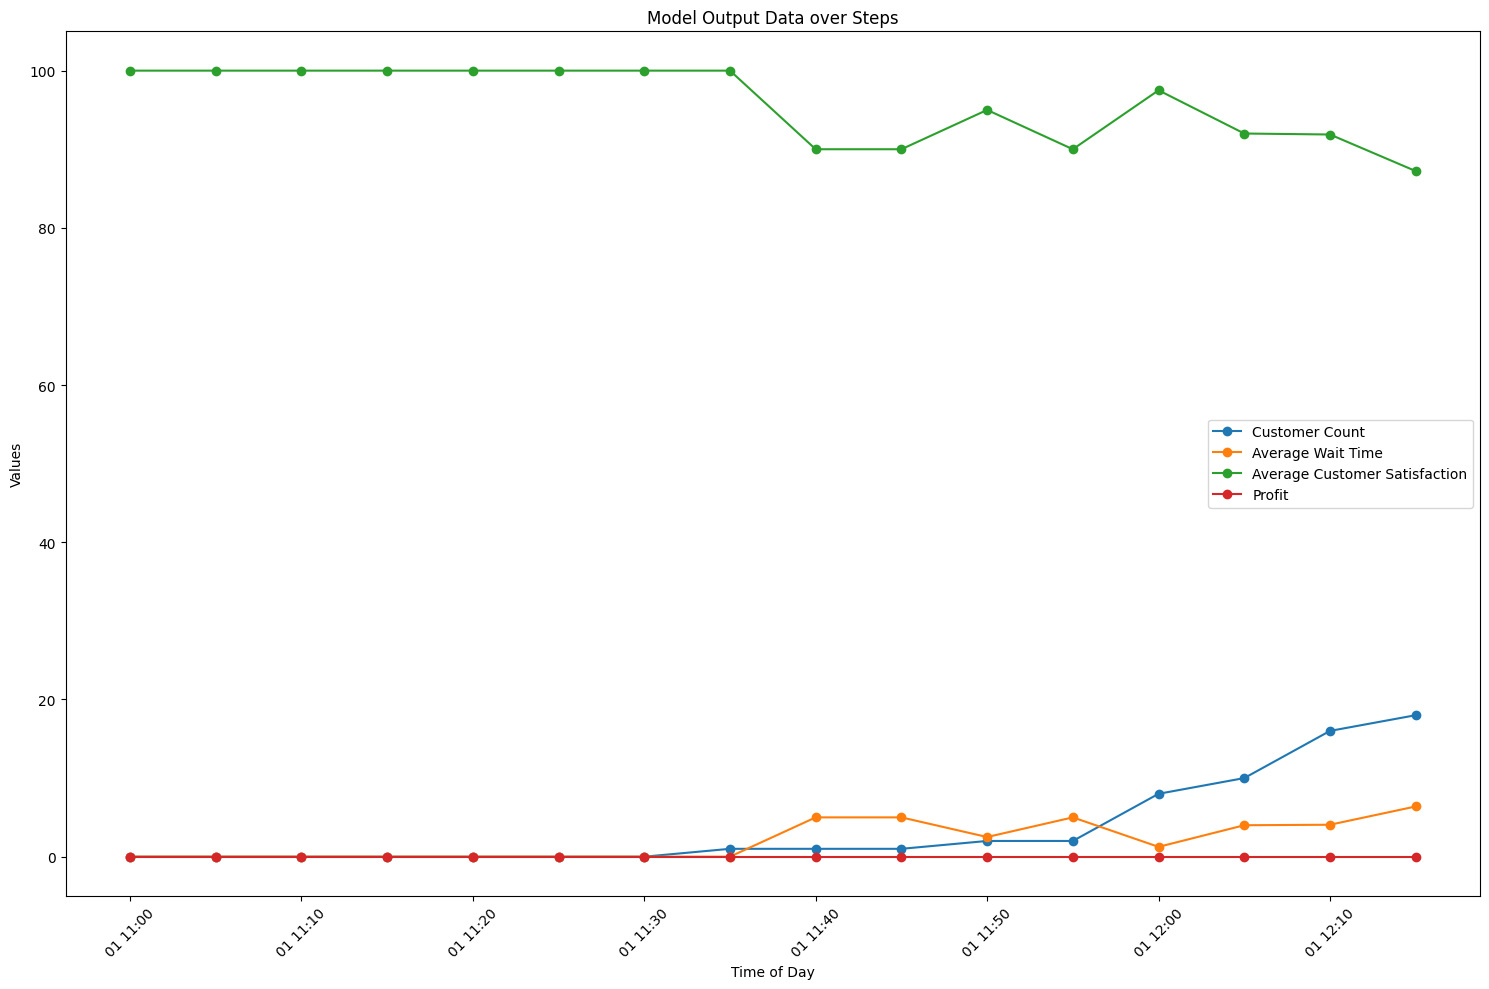

None


None


None


None


None


None


In [6]:
df_mean_step = display_mean_step_results(results)
df_first_run_customer = display_first_run_step_results_customer(results)
df_first_run_waiter = display_first_run_step_results_waiter(results)

In [12]:
df = pd.DataFrame(results)
data_first_run = df[df["RunId"] == 0]

data_first_run['Time'] = data_first_run['Step'].apply(
    lambda x: pd.Timestamp('2024-01-01 11:00:00') + pd.Timedelta(minutes=x * 5))

data_first_run
daily_stats_dict = dict(zip(data_first_run["Time"], data_first_run["Daily_Stats"]))
#daily_stats_list = [{**item, 'time': k} for k, v in daily_stats_dict.items() for item in v]
#daily_stats_df = pd.DataFrame(daily_stats_list)

print(daily_stats_dict)

#waiter_infos_df

#plots = ['tips', 'avg_rating', 'served_customers']
#for plot in plots:
#    fig = px.histogram(waiter_infos_df, x="time", y=plot,
#                        color='waiter_nr', barmode='group',
#                        height=400, nbins=len(waiter_infos_df['time'].unique()))
#    print(fig.show())

{Timestamp('2024-01-01 11:00:00'): {'day': 1, 'food_revenue': 0, 'tips': 0, 'total_revenue': 0, 'customers_paid': 0, 'customers_left': 0, 'served_customers': 0}, Timestamp('2024-01-01 11:05:00'): {'day': 1, 'food_revenue': 0, 'tips': 0, 'total_revenue': 0, 'customers_paid': 0, 'customers_left': 0, 'served_customers': 0}, Timestamp('2024-01-01 11:10:00'): {'day': 1, 'food_revenue': 0, 'tips': 0, 'total_revenue': 0, 'customers_paid': 0, 'customers_left': 0, 'served_customers': 0}, Timestamp('2024-01-01 11:15:00'): {'day': 1, 'food_revenue': 0, 'tips': 0, 'total_revenue': 0, 'customers_paid': 0, 'customers_left': 0, 'served_customers': 0}, Timestamp('2024-01-01 11:20:00'): {'day': 1, 'food_revenue': 0, 'tips': 0, 'total_revenue': 0, 'customers_paid': 0, 'customers_left': 0, 'served_customers': 0}, Timestamp('2024-01-01 11:25:00'): {'day': 1, 'food_revenue': 0, 'tips': 0, 'total_revenue': 0, 'customers_paid': 0, 'customers_left': 0, 'served_customers': 0}, Timestamp('2024-01-01 11:30:00'):

In [13]:
df = pd.DataFrame(results)
data_first_run = df[df["RunId"] == 0]

data_first_run['Time'] = data_first_run['Step'].apply(
    lambda x: pd.Timestamp('2024-01-01 11:00:00') + pd.Timedelta(minutes=x * 5))

waiter_infos_dict = dict(zip(data_first_run["Time"], data_first_run["Waiter_Info"]))
print(waiter_infos_dict)

{Timestamp('2024-01-01 11:00:00'): [{'waiter_nr': 1, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 2, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 3, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 4, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 5, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 6, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 7, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 8, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 9, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 10, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}], Timestamp('2024-01-01 11:05:00'): [{'waiter_nr': 1, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 2, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 3, 'tips': 0, 'avg_rating': 0, 'served_customers': 0}, {'waiter_nr': 4, 'tips': 0, 'a

In [7]:
df_mean_step

,Time,mean_customer_count,mean_waiting_time,mean_customer_satisfaction,mean_profit
0,2024-01-01 11:00:00,0.0,0.000000,100.000000,0.0
1,2024-01-01 11:05:00,0.0,0.000000,100.000000,0.0
2,2024-01-01 11:10:00,0.0,0.000000,100.000000,0.0
3,2024-01-01 11:15:00,0.0,0.000000,100.000000,0.0
4,2024-01-01 11:20:00,0.0,0.000000,100.000000,0.0
5,2024-01-01 11:25:00,0.0,0.000000,100.000000,0.0
6,2024-01-01 11:30:00,0.0,0.000000,100.000000,0.0
7,2024-01-01 11:35:00,1.0,0.000000,100.000000,0.0
8,2024-01-01 11:40:00,1.0,5.000000,90.000000,0.0
9,2024-01-01 11:45:00,1.0,5.000000,90.000000,0.0
